# Test of YOLOv4 for Screen Detection

In [23]:
import glob as glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import swifter
from IPython.display import clear_output
from sklearn.metrics import (
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    roc_auc_score,
)

%matplotlib inline
sns.set()

## Model Setup

In [2]:
# Load the data
if os.name == "nt":  # Running on PC
    # Label Names
    LABELS = (
        open(
            r"C:\Users\taren\Google Drive\ACU Google Account\Projects\Square Eyes (DP20)\Data collection and management\Image Blurring Test\Yolo\coco.names"
        )
        .read()
        .strip()
        .split("\n")
    )

    # Model Weights and Config
    configpath = r"C:\Users\taren\Google Drive\ACU Google Account\Projects\Square Eyes (DP20)\Data collection and management\Image Blurring Test\Yolo\yolov4.cfg"
    weightspath = r"C:\Users\taren\Google Drive\ACU Google Account\Projects\Square Eyes (DP20)\Data collection and management\Image Blurring Test\Yolo\yolov4.weights"

    # Coded data
    coded_data = pd.read_csv(
        r"Z:\Screen_Time_Measure_Development\SNAP_IT\Coding Framework Test Images\Screen Time Coding Data - Device.csv"
    )

    # Folder with the images
    folder = r"Z:\Screen_Time_Measure_Development\SNAP_IT\Coding Framework Test Images"

else:  # Running on my Mac
    LABELS = (
        open(
            "/Users/tasanders/Google Drive/Square Eyes (DP20)/5 - Data collection and management/Image Blurring Test/Yolo/coco.names"
        )
        .read()
        .strip()
        .split("\n")
    )

    configpath = "/Users/tasanders/Google Drive/Square Eyes (DP20)/5 - Data collection and management/Image Blurring Test/Yolo/yolov4.cfg"
    weightspath = "/Users/tasanders/Google Drive/Square Eyes (DP20)/5 - Data collection and management/Image Blurring Test/Yolo/yolov4.weights"

    # Coded data
    coded_data = pd.read_csv(
        "/Volumes/M&B/Screen_Time_Measure_Development/SNAP_IT/Coding Framework Test Images/Screen Time Coding Data - Device.csv"
    )

    # Folder with the images
    folder = "/Volumes/M&B/Screen_Time_Measure_Development/SNAP_IT/Coding Framework Test Images"

In [3]:
# Labels indicating a screen
cat_def = [
    "tvmonitor",
    "laptop",
    "cell phone",
]

# Labels that might indicate a screen
cat_maybe = [
    "mouse",
    "remote",
    "keyboard",
]

In [4]:
def predict_screen(file, conf_thresh, nms_thresh):

    # Get the weights and config
    # Would be faster to do this once, but then couldn't use swifter
    net = cv2.dnn.readNet(configpath, weightspath)

    # Determine the output layer names
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # Convert the file to a cv2 object
    im = cv2.imread(file)

    # Get the dimensions of the image
    (H, W) = im.shape[:2]

    # Do the required preprocessing on the image (the 'blob')
    blob = cv2.dnn.blobFromImage(im, 1 / 255.0, (416, 416), swapRB=True, crop=False)

    # Pass the blob through the network (the 'forward pass') and get the outputs
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # Translate the predictions
    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf_thresh:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                # update our list of bounding box coordinates, confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_thresh, nms_thresh)

    # There are two scores: one using 'definitely' a screen, and one for 'maybe' a screen.
    def_screens = []
    maybe_screens = []

    if len(idxs):  # Check if there were any predictions
        for i in idxs.flatten():  # The predictions are nested
            if LABELS[classIDs[i]] in cat_def:
                def_screens.append(confidences[i])
            elif LABELS[classIDs[i]] in cat_maybe:
                maybe_screens.append(confidences[i])

    return def_screens, maybe_screens


def calc_prob(probs):
    """
    Calculates the probability of there being no screen, if there are multiple predictions of screens.
    """

    result = 1
    for prob in probs:
        result = result * (1 - prob)

    return 1 - result


def process_row(row):
    try:
        defin, maybe = predict_screen(
            glob.glob(os.path.join(folder, "*", row["filename"]))[0],
            conf_thresh=0.2,
            nms_thresh=0.2,
        )
    except:
        return pd.Series([np.NaN, np.NaN, np.NaN, np.NaN])

    # Add the probabilities from defin into maybe
    maybe = defin + maybe

    if len(defin):
        defin_cond_prob = calc_prob(defin)
        defin_max = max(defin)
    else:
        defin_cond_prob = 0
        defin_max = 0

    if len(maybe):
        maybe_cond_prob = calc_prob(maybe)
        maybe_max = max(maybe)
    else:
        maybe_cond_prob = 0
        maybe_max = 0

    return pd.Series([defin_max, defin_cond_prob, maybe_max, maybe_cond_prob])

In [7]:
%%time
coded_data[
    [
        "Definite Screen - Max Prob",
        "Definite Screen - Conditional Prob",
        "Maybe Screen - Max Prob",
        "Maybe Screen - Conditional Prob",
    ]
] = (
    coded_data.swifter.set_dask_threshold(0)
    .allow_dask_on_strings(True)
    .apply(process_row, axis=1)
)


Wall time: 31min 7s


##  Test against pre-coded data

In [34]:
# Make a copy of the dataframe in case I make a mistake
coded_data_backup = coded_data.copy()

In [87]:
# Create columns at various confidence levels
for x in np.arange(0.2, 0.51, 0.05):
    coded_data["screen_def_cond_" + str(round(x, 2))] = np.where(
        coded_data["Definite Screen - Conditional Prob"] >= x, True, False
    )
    coded_data["screen_maybe_cond_" + str(round(x, 2))] = np.where(
        coded_data["Maybe Screen - Conditional Prob"] >= x, True, False
    )

In [88]:
predicted_devices = coded_data.drop(
    columns=[
        "filename",
        "device",
        "device_excl_bkg",
        "Definite Screen - Max Prob",
        "Definite Screen - Conditional Prob",
        "Maybe Screen - Max Prob",
        "Maybe Screen - Conditional Prob",
    ]
)

In [89]:
# Print the classification matrix at different levels of confidence
max_roc = 0
for predicted_device in predicted_devices:
    print(f"Comparing: {predicted_device}")
    print(classification_report(coded_data["device"], coded_data[predicted_device]))
    roc_score = roc_auc_score(coded_data["device"], coded_data[predicted_device])
    print(f"ROC: {roc_score}\n")
    if roc_score > max_roc:
        max_roc = roc_score
        max_roc_cond = predicted_device

Comparing: screen_def_cond_0.2
              precision    recall  f1-score   support

       False       0.70      0.91      0.79      1484
        True       0.95      0.81      0.87      3012

    accuracy                           0.84      4496
   macro avg       0.82      0.86      0.83      4496
weighted avg       0.87      0.84      0.85      4496

ROC: 0.8585505238703764

Comparing: screen_maybe_cond_0.2
              precision    recall  f1-score   support

       False       0.71      0.90      0.79      1484
        True       0.94      0.82      0.88      3012

    accuracy                           0.85      4496
   macro avg       0.83      0.86      0.84      4496
weighted avg       0.87      0.85      0.85      4496

ROC: 0.8603420997054012

Comparing: screen_def_cond_0.25
              precision    recall  f1-score   support

       False       0.68      0.93      0.79      1484
        True       0.96      0.79      0.86      3012

    accuracy                        

In [ ]:
print(f"The best results came from: {max_roc_cond}")
print(classification_report(coded_data["device"], coded_data[max_roc_cond]))
print(f"ROC: {roc_auc_score(coded_data['device'], coded_data[max_roc_cond])}")

## Graphing the Results

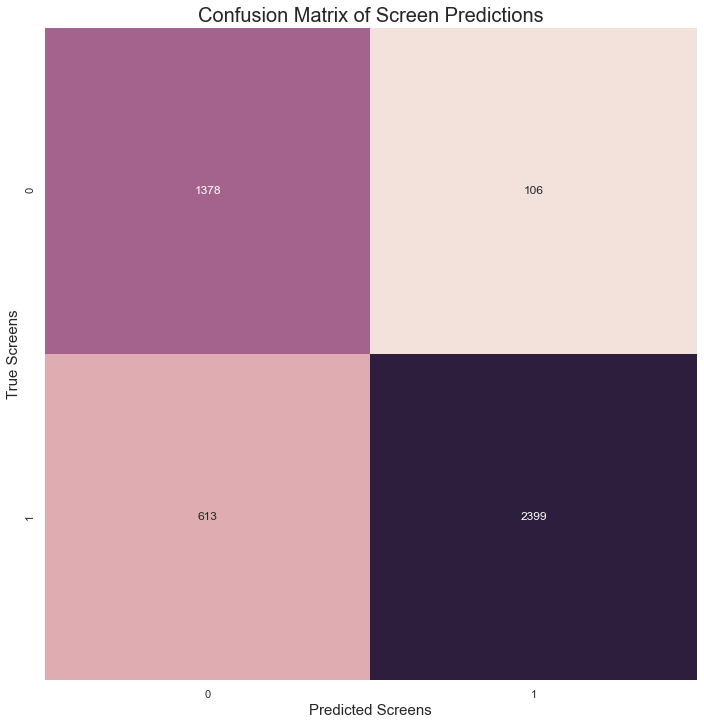

In [102]:
conf_mat = confusion_matrix(coded_data["device"], coded_data[max_roc_cond])
fig = plt.figure(figsize=(12, 12))
sns.heatmap(
    conf_mat,
    square=True,
    annot=True,
    fmt="d",
    cbar=False,
    cmap=sns.cubehelix_palette(light=0.9, as_cmap=True),
)
plt.xlabel("Predicted Screens", fontsize=15)
plt.ylabel("True Screens", fontsize=15)
plt.title("Confusion Matrix of Screen Predictions", fontsize=20)
plt.savefig("ConfMat.png")